<h1>About this Notebook</h1>

This notebook demonstrates the experience of using ML Workbench to create a machine learning model for text classification and setting it up for online prediction. Training the model is done "locally" inside Datalab. In the next notebook (Text Classification --- 20NewsGroup (large data)), it demonstrates how to do it by using Cloud ML Engine services.

If you have any feedback, please send them to datalab-feedback@google.com.

# Data   

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics. The classification problem is to identify the newsgroup a post was summited to, given the text of the post.

There are a few versions of this dataset from different sources online. Below, we use the version within scikit-learn which is already split into a train and test/eval set. For a longer introduction to this dataset, see the [scikit-learn website](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)

## Download Data

In [1]:
# Set up a new directory and make it working directory

!mkdir -p /content/datalab/workspace/text_classification_20newsgroup

import os
os.chdir('/content/datalab/workspace/text_classification_20newsgroup')

In [2]:
import numpy as np
import pandas as pd
import os
import re
import csv
from sklearn.datasets import fetch_20newsgroups

In [3]:
# data will be downloaded. Note that an error message saying something like "No handlers could be found for 
# logger sklearn.datasets.twenty_newsgroups" might be printed, but this is not an error.
news_train_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
news_test_data = fetch_20newsgroups(subset='test', shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))

No handlers could be found for logger "sklearn.datasets.twenty_newsgroups"


## Cleaning the Raw Data

Printing the 3rd element in the test dataset shows the data contains text with newlines, punctuation, misspellings, and other items common in text documents. To build a model, we will clean up the text by removing some of these issues.

In [4]:
news_train_data.data[2], news_train_data.target_names[news_train_data.target[2]]

(u'well folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985.  sooo, i\'m in the market for a\nnew machine a bit sooner than i intended to be...\n\ni\'m looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected?  i\'d heard the 185c was supposed to make an\nappearence "this summer" but haven\'t heard anymore on it - and since i\ndon\'t have access to macleak, i was wondering if anybody out there had\nmore info...\n\n* has anybody heard rumors about price drops to the powerbook line like the\nones the duo\'s just went through recently?\n\n* what\'s the impression of the display on the 180?  i could probably swing\na 180 if i got the 80Mb disk rather than the 120, but i don\'t really have\na feel for how much "better" the display is (yea, it looks great in the\nstore, but is tha

In [5]:
def clean_and_tokenize_text(news_data):
    """Cleans some issues with the text data
    Args:
        news_data: list of text strings
    Returns:
        For each text string, an array of tokenized words are returned in a list
    """
    cleaned_text = []
    for text in news_data:
        x = re.sub('[^\w]|_', ' ', text)  # only keep numbers and letters and spaces
        x = x.lower()
        x = re.sub(r'[^\x00-\x7f]',r'', x)  # remove non ascii texts
        tokens = [y for y in x.split(' ') if y] # remove empty words
        tokens = ['[number]' if x.isdigit() else x for x in tokens] # convert all numbers to '[number]' to reduce vocab size.
        cleaned_text.append(tokens)
    return cleaned_text

In [6]:
clean_train_tokens = clean_and_tokenize_text(news_train_data.data)
clean_test_tokens = clean_and_tokenize_text(news_test_data.data)

## Get Vocabulary

We will need to filter the vocabulary to remove high frequency words and low frequency words.

In [7]:
def get_unique_tokens_per_row(text_token_list):
    """Collect unique tokens per row.
    Args:
        text_token_list: list, where each element is a list containing tokenized text
    Returns:
        One list containing the unique tokens in every row. For example, if row one contained
        ['pizza', 'pizza'] while row two contained ['pizza', 'cake', 'cake'], then the output list
        would contain ['pizza' (from row 1), 'pizza' (from row 2), 'cake' (from row 2)]
    """
    words = []
    for row in text_token_list:
        words.extend(list(set(row)))
    return words

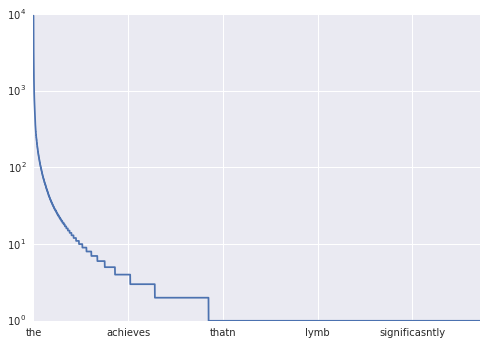

In [8]:
# Make a plot where the x-axis is a token, and the y-axis is how many text documents
# that token is in. 
words = pd.DataFrame(get_unique_tokens_per_row(clean_train_tokens) , columns=['words'])
token_frequency = words['words'].value_counts() # how many documents contain each token.
token_frequency.plot(logy=True)

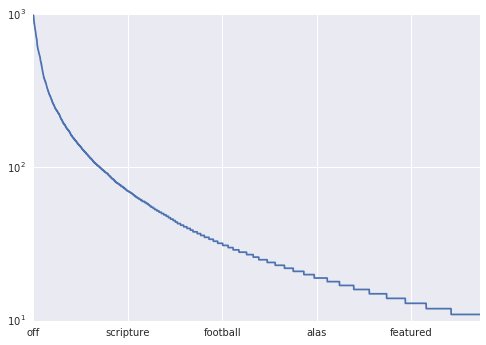

In [9]:
vocab = token_frequency[np.logical_and(token_frequency < 1000, token_frequency > 10)]
vocab.plot(logy=True)

In [10]:
def filter_text_by_vocab(news_data, vocab):
    """Removes tokens if not in vocab.
    Args:
        news_data: list, where each element is a token list
        vocab: set containing the tokens to keep.
    Returns:
        List of strings containing the final cleaned text data
    """
    text_strs = []
    for row in news_data:
        words_to_keep = [token for token in row if token in vocab or token == '[number]']
        text_strs.append(' '.join(words_to_keep))
    return text_strs

In [11]:
clean_train_data = filter_text_by_vocab(clean_train_tokens, set(vocab.index))
clean_test_data = filter_text_by_vocab(clean_test_tokens, set(vocab.index))

In [12]:
# Check a few instances of cleaned data

clean_train_data[:3]

[u'wondering enlighten car saw day [number] door sports car looked late 60s early 70s called doors small addition front bumper separate rest body model name engine specs years production car made history whatever info looking car e mail',
 u'fair number brave souls upgraded si clock oscillator shared experiences poll send brief message detailing experiences procedure top speed cpu rated speed add cards adapters heat hour usage per day floppy disk functionality [number] [number] [number] floppies especially requested next days add network knowledge base done clock upgrade haven answered poll',
 u'folks mac plus finally gave ghost weekend starting life 512k [number] market machine bit sooner intended looking picking powerbook [number] maybe [number] bunch questions hopefully somebody answer anybody dirt next round powerbook expected heard supposed summer haven heard anymore access wondering anybody info anybody heard rumors price drops powerbook line ones duo went through recently impres

## Save the Cleaned Data For Training

In [13]:
!mkdir -p ./data

with open('./data/train.csv', 'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    for target, text in zip(news_train_data.target, clean_train_data):
        writer.writerow([news_train_data.target_names[target], text])
        
with open('./data/eval.csv', 'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    for target, text in zip(news_test_data.target, clean_test_data):
        writer.writerow([news_test_data.target_names[target], text]) 
        
# Also save the vocab, which will be useful in making new predictions.
with open('./data/vocab.txt', 'w') as f:
    vocab.to_csv(f)

# Create Model with ML Workbench


The MLWorkbench Magics are a set of Datalab commands that allow an easy code-free experience to training, deploying, and predicting ML models. This notebook will take the cleaned data from the previous notebook and build a text classification model. The MLWorkbench Magics are a collection of magic commands for each step in ML workflows: analyzing input data to build transforms, transforming data, training a model, evaluating a model, and deploying a model.

For details of each command, run with --help. For example, "%%ml train --help".

When the dataset is small (like with the 20 newsgroup data), there is little benefit of using cloud services. This notebook will run the analyze, transform, and training steps locally. However, we will take the locally trained model and deploy it to ML Engine and show how to make real predictions on a deployed model. Every MLWorkbench magic can run locally or use cloud services (adding --cloud flag).

The next notebook (Text Classification --- 20NewsGroup (large data)) in this sequence shows the cloud version of every command, and gives the normal experience when building models are large datasets. However, we will still use the 20 newsgroup data. 


In [2]:
import google.datalab.contrib.mlworkbench.commands  # This loads the '%%ml' magics
import google.datalab

# Other imports
import json

First, define the dataset we are going to use for training.

In [4]:
%%ml dataset create
name: newsgroup_data
format: csv
train: ./data/train.csv
eval: ./data/eval.csv
schema:
    - name: news_label
      type: STRING
    - name: text
      type: STRING

In [5]:
%%ml dataset explore
name: newsgroup_data

train data instances: 11314
eval data instances: 7532


## Step 1: Analyze
The first step in the MLWorkbench workflow is to analyze the data for the requested transformations. We are going to build a bag of words representation on the text and use this in a linear model. Therefore, the analyze step will compute the vocabularies and related statistics of the data for traing.

In [6]:
%%ml analyze
output: ./analysis
training_data: newsgroup_data
features:
    news_label:
        transform: target
    text:
        transform: bag_of_words

Expanding any file patterns...
file list computed.
Analyzing file /content/datalab/workspace/text_classification_20newsgroup/data/train.csv...
file /content/datalab/workspace/text_classification_20newsgroup/data/train.csv analyzed.


In [7]:
!ls ./analysis

features.json  schema.json  stats.json	vocab_news_label.csv  vocab_text.csv


## Step 2: Transform

This step is optional as training can start from csv data (the same data used in the analysis step). The transform step performs some transformations on the input data and saves the results to a special TensorFlow file called a TFRecord file containing TF.Example protocol buffers. This allows training to start from preprocessed data. If this step is not used, training would have to perform the same preprocessing on every row of csv data every time it is used. As TensorFlow reads the same data row multiple times during training, this means the same row would be preprocessed multiple times. By writing the preprocessed data to disk, we can speed up training. Because the the 20 newsgroups data is small, this step does not matter, but we do it anyway for illustration. This step is recommended if there are text column in a dataset, and required if there are image columns in a dataset.

We run the transform step for the training and eval data.

In [8]:
!rm -rf ./transform

In [9]:
%%ml transform --shuffle
output: ./transform
analysis: ./analysis
training_data: newsgroup_data

/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:135: UserWarning: Using fallback coder for typehint: Any.
  warnings.warn('Using fallback coder for typehint: %r.' % typehint)
2017-10-17 19:38:14.541388: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-10-17 19:38:14.541413: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-10-17 19:38:14.541422: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-10-17 19:38:14.541431: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 i

In [10]:
# note: the errors_* files are all 0 size, which means no error.
!ls ./transform/ -l -h

total 3.1M
-rw-r--r-- 1 root root    0 Oct 17 19:38 errors_eval-00000-of-00001.txt
-rw-r--r-- 1 root root    0 Oct 17 19:38 errors_train-00000-of-00001.txt
-rw-r--r-- 1 root root 1.2M Oct 17 19:38 eval-00000-of-00001.tfrecord.gz
-rw-r--r-- 1 root root 2.0M Oct 17 19:38 train-00000-of-00001.tfrecord.gz


Create a "transformed dataset" to use in next step.

In [12]:
%%ml dataset create
name: newsgroup_transformed
train: ./transform/train-*
eval: ./transform/eval-*
format: transformed  

## Step 3: Training

MLWorkbench automatically builds standard TensorFlow models without you having to write any TensorFlow code. 

In [13]:
# Training should use an empty output folder. So if you run training multiple times,
# use different folders or remove the output from the previous run.
!rm -fr ./train

The following training step takes about 10~15 minutes.

In [14]:
%%ml train
output: ./train
analysis: ./analysis/
training_data: $newsgroup_transformed
model_args:
    model: linear_classification
    top-n: 5

TensorBoard was started successfully with pid 22958. Click here to access it.

Go to Tensorboard (link shown above) to monitor the training progress. Note that training stops when it detects accuracy is no longer increasing for eval data.

In [15]:
# You can also plot the summary events which will be saved with the notebook.

from google.datalab.ml import Summary

summary = Summary('./train')
summary.list_events()

{u'accuracy': {'./train/train/eval'},
 u'global_step/sec': {'./train/train'},
 u'input_producer/fraction_of_32_full': {'./train/train'},
 u'loss': {'./train/train', './train/train/eval'},
 u'shuffle_batch/fraction_over_10_of_960_full': {'./train/train'}}

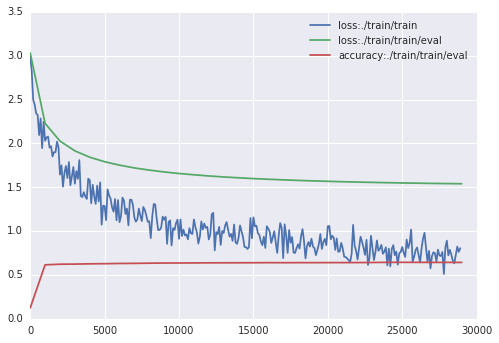

In [16]:
summary.plot(['loss', 'accuracy'])

The output of training is two models, one in training_output/model and another in training_output/evaluation_model. These tensorflow models are identical except the latter assumes the target column is part of the input and copies the target value to the output. Therefore, the latter is ideal for evaluation.

In [27]:
!ls ./train/model

assets.extra  saved_model.pb  variables


## Step 4: Evaluation using batch prediction

Below, we use the evaluation model and run batch prediction locally. Batch prediction is needed for large datasets where the data cannot fit in memory. For demo purpose, we will use the training evaluation data again.

In [17]:
%%ml batch_predict
model: ./train/evaluation_model/
output: ./batch_predict
format: csv
prediction_data:
    csv: ./data/eval.csv

local prediction...
INFO:tensorflow:Restoring parameters from ./train/evaluation_model/variables/variables
done.


In [18]:
# It creates a results csv file, and a results schema json file.
!ls ./batch_predict

predict_results_eval.csv  predict_results_schema.json


Note that the output of prediction is a csv file containing the score for each label class. 'predicted_n' is the label for the nth largest score. We care about 'predicted', the final model prediction. 

In [19]:
!head -n 5 ./batch_predict/predict_results_eval.csv

rec.autos,comp.sys.mac.hardware,rec.sport.baseball,sci.space,soc.religion.christian,0.374961,0.223007,0.0782221,0.0495947,0.0372713,rec.autos
comp.graphics,comp.windows.x,sci.space,rec.motorcycles,comp.os.ms-windows.misc,0.509809,0.301426,0.0250255,0.0206116,0.0193489,comp.windows.x
rec.motorcycles,rec.sport.baseball,comp.os.ms-windows.misc,alt.atheism,comp.sys.mac.hardware,0.0747842,0.0708097,0.0658317,0.05767,0.0541744,alt.atheism
talk.politics.guns,talk.politics.mideast,alt.atheism,talk.politics.misc,sci.crypt,0.416234,0.351695,0.134796,0.0944993,0.00145118,talk.politics.mideast
alt.atheism,rec.autos,talk.religion.misc,sci.space,comp.sys.mac.hardware,0.154862,0.0754523,0.0753221,0.0675569,0.0630613,talk.religion.misc


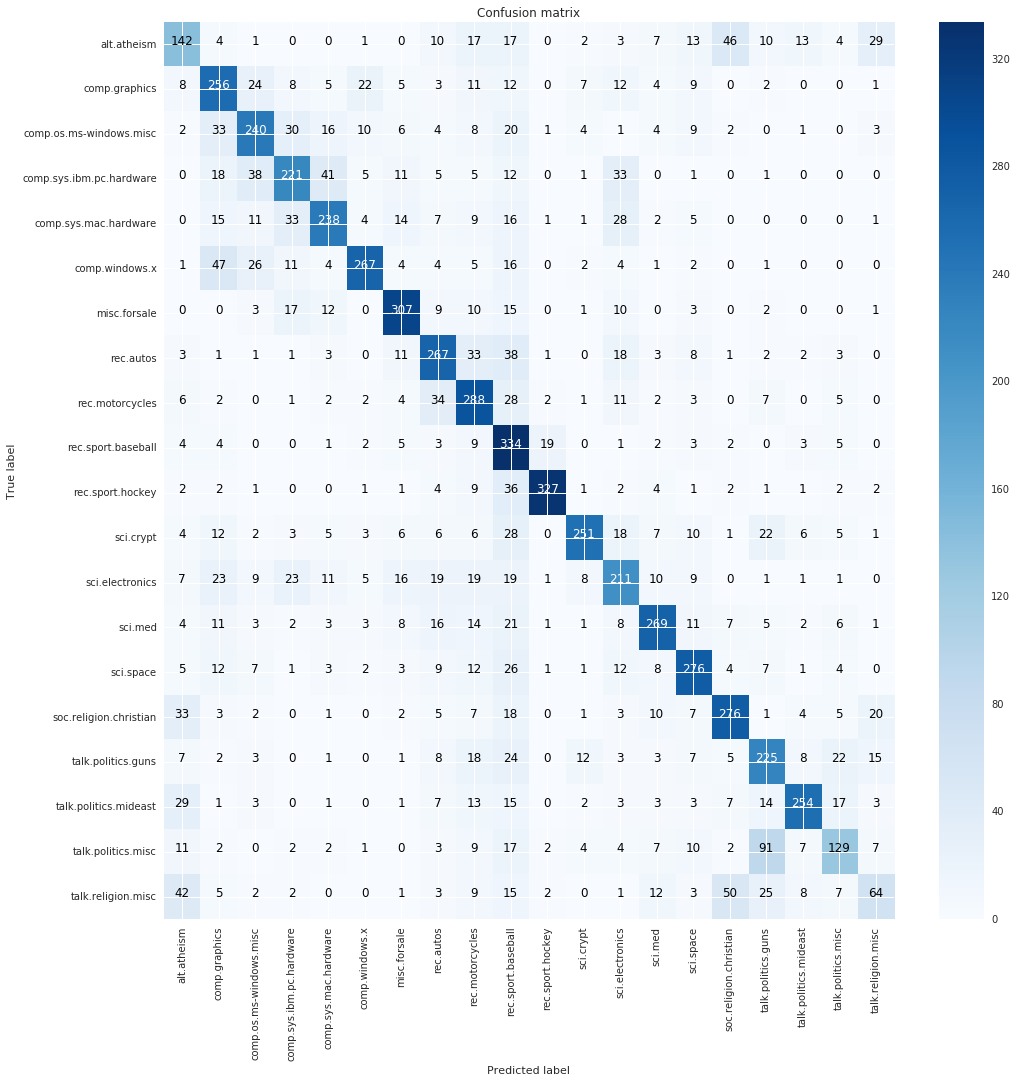

In [20]:
%%ml evaluate confusion_matrix --plot
csv: ./batch_predict/predict_results_eval.csv

In [21]:
%%ml evaluate accuracy
csv: ./batch_predict/predict_results_eval.csv

,accuracy,count,target
0,0.445141,319,alt.atheism
1,0.658098,389,comp.graphics
2,0.609137,394,comp.os.ms-windows.misc
3,0.563776,392,comp.sys.ibm.pc.hardware
4,0.618182,385,comp.sys.mac.hardware
5,0.675949,395,comp.windows.x
6,0.787179,390,misc.forsale
7,0.674242,396,rec.autos
8,0.723618,398,rec.motorcycles
9,0.841310,397,rec.sport.baseball


## Step 5: BigQuery to analyze evaluate results

Sometimes you want to query your prediction/evaluation results using SQL. It is easy.

In [165]:
# Create bucket
!gsutil mb gs://bq-mlworkbench-20news-lab
!gsutil cp -r ./batch_predict/predict_results_eval.csv gs://bq-mlworkbench-20news-lab

Creating gs://bq-mlworkbench-20news-lab/...
ServiceException: 409 Bucket bq-mlworkbench-20news-lab already exists.
Copying file://./batch_predict/predict_results_eval.csv [Content-Type=text/csv]...
/ [1 files][697.1 KiB/697.1 KiB]                                                
Operation completed over 1 objects/697.1 KiB.                                    


In [166]:
# Use Datalab's Bigquery API to load CSV files into table.

import google.datalab.bigquery as bq
import json

with open('./batch_predict/predict_results_schema.json', 'r') as f:
    schema = json.load(f)

# Create BQ Dataset
bq.Dataset('newspredict').create()

# Create the table
table = bq.Table('newspredict.result1').create(schema=schema, overwrite=True)
table.load('gs://bq-mlworkbench-20news-lab/predict_results_eval.csv', mode='overwrite',
           source_format='csv', csv_options=bq.CSVOptions(skip_leading_rows=1))

Job bradley-playground/job_qiBO9lW4tEGq4XHFVMN7f9lpXfhI completed

Now, run any SQL queries on "table newspredict.result1". Below we query all wrong predictions.

In [168]:
%%bq query
SELECT * FROM newspredict.result1 WHERE predicted != target

predicted,predicted_2,predicted_3,probability,probability_2,probability_3,target
sci.space,sci.med,rec.autos,0.086385,0.0773015,0.0725528,sci.med
rec.sport.baseball,sci.med,rec.autos,0.108085,0.0840068,0.0808425,sci.med
soc.religion.christian,sci.med,rec.autos,0.166548,0.119935,0.0955845,sci.med
misc.forsale,sci.med,sci.space,0.129705,0.110822,0.0921078,sci.med
sci.electronics,sci.med,sci.space,0.844139,0.14984,0.00210459,sci.med
comp.graphics,sci.med,misc.forsale,0.115064,0.0961417,0.0907061,sci.med
sci.electronics,sci.med,misc.forsale,0.279434,0.169235,0.151345,sci.med
rec.motorcycles,sci.med,comp.graphics,0.110692,0.0906959,0.0819244,sci.med
comp.graphics,sci.med,comp.windows.x,0.178217,0.153884,0.0879586,sci.med
comp.sys.ibm.pc.hardware,sci.med,comp.windows.x,0.161895,0.146294,0.123733,sci.med


# Prediction

## Local Instant Prediction

The MLWorkbench also supports running prediction and displaying the results within the notebook. Note that we use the non-evaluation model below (./train/model) which takes input with no target column.

In [37]:
%%ml predict
model: ./train/model/
headers: text
prediction_data:
  - nasa
  - windows xp

predicted,predicted_2,predicted_3,predicted_4,predicted_5,probability,probability_2,probability_3,probability_4,probability_5,text
sci.space,rec.motorcycles,rec.sport.baseball,comp.graphics,rec.autos,0.093669,0.063219,0.061134,0.060603,0.057013,nasa
comp.os.ms-windows.misc,comp.graphics,comp.windows.x,misc.forsale,rec.motorcycles,0.144150,0.065617,0.063927,0.062258,0.056340,windows xp


## Why Does My Model Predict this? Prediction Explanation.

"%%ml explain" gives you insights on what are important features in the prediction data that contribute positively or negatively to certain labels. We use LIME under "%%ml explain". ([LIME](https://github.com/marcotcr/lime) is an open sourced library performing feature sensitivity analysis. It is based on the work presented in [this paper](https://arxiv.org/abs/1602.04938). LIME is included in Datalab.)

In this case, we will check which words in text are contributing most to the predicted label. 

In [22]:
# Pick some data from eval csv file. They are cleaned text.
# The truth labels for the following 3 instances are
# - rec.autos
# - comp.windows.x
# - talk.politics.mideast

instance0 = ('little confused models [number] [number] heard le se someone tell differences far features ' +
            'performance curious book value [number] model less book value usually words demand ' +
            'year heard mid spring early summer best buy')
instance1 = ('hi requirement closing opening different display servers within x application manner display ' +
            'associated client proper done during transition problems')
instance2 = ('attacking drive kuwait country whose citizens close blood business ties saudi citizens thinks ' +
            'helped saudi arabia least eastern muslim country doing anything help kuwait protect saudi arabia ' +
            'indeed masses citizens demonstrating favor butcher saddam killed muslims killing relatively rich ' +
            'muslims nose west saudi arabia rolled iraqi invasion charge saudi arabia idea governments official ' +
            'religion de facto de human nature always ones rise power world country citizens leader slick ' +
            'operator sound guys angels posting edited stuff following friday york times reported group definitely ' +
            'conservative followers house rule country enough reported besides complaining government conservative ' +
            'enough asserted approx [number] [number] kingdom charge under saudi islamic law brings death penalty ' +
            'diplomatic guy bin isn called severe punishment [number] women drove public while protest ban women ' +
            'driving guy group said al said women fired jobs happen heard muslims ban women driving basis qur etc ' +
            'yet folks ban women called choose rally behind hate women allowed tv radio immoral kingdom house neither ' +
            'least nor favorite government earth restrict religious political lot among things likely replacements ' +
            'going lot worse citizens country house feeling heat lately last six months read religious police ' +
            'government western women fully stupid women imo sends wrong signals morality read cracked down few home ' +
            'based religious posted government owned newspapers offering money turns group dare worship homes secret ' +
            'place government grown try take wind conservative opposition things small taste happen guys house trying ' +
            'long run others general west evil zionists rule hate west crowd')

data = [instance0, instance1, instance2]

In [23]:
%%ml predict
model: ./train/model/
headers: text
prediction_data: $data

predicted,predicted_2,predicted_3,predicted_4,predicted_5,probability,probability_2,probability_3,probability_4,probability_5,text
rec.autos,comp.sys.mac.hardware,rec.sport.baseball,sci.space,soc.religion.christian,0.374961,0.223007,0.078222,0.049595,0.037271,little confused models [number] [numb...
comp.windows.x,comp.graphics,comp.sys.mac.hardware,sci.space,comp.os.ms-windows.misc,0.601730,0.062495,0.053911,0.039315,0.036243,hi requirement closing opening differ...
talk.politics.guns,talk.politics.mideast,alt.atheism,talk.politics.misc,sci.crypt,0.416234,0.351695,0.134796,0.094499,0.001451,attacking drive kuwait country whose ...


The first and second instances are predicted correctly. The third is wrong. Below we run "%%ml explain" to understand more.

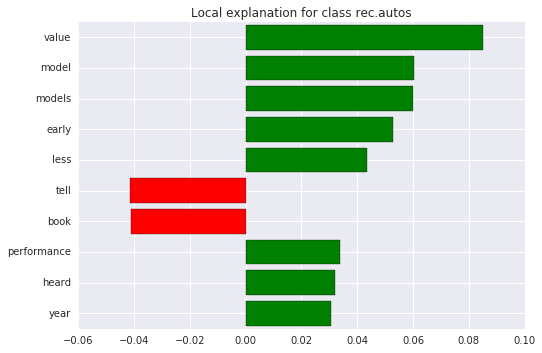

In [26]:
%%ml explain --detailview_only
model: ./train/model
labels: rec.autos
type: text
data: $instance0

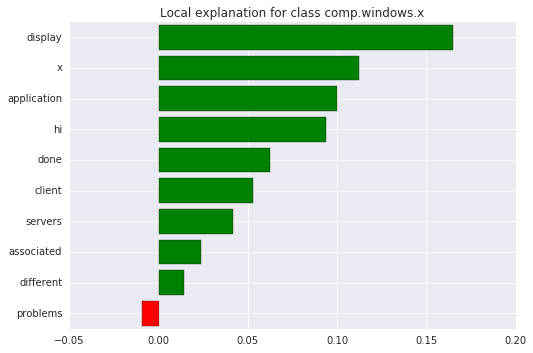

In [25]:
%%ml explain --detailview_only
model: ./train/model
labels: comp.windows.x
type: text
data: $instance1

On instance 2, the top prediction result does not match truth. Predicted is "talk.politics.guns" while truth is "talk.politics.mideast". So let's analyze these two labels.

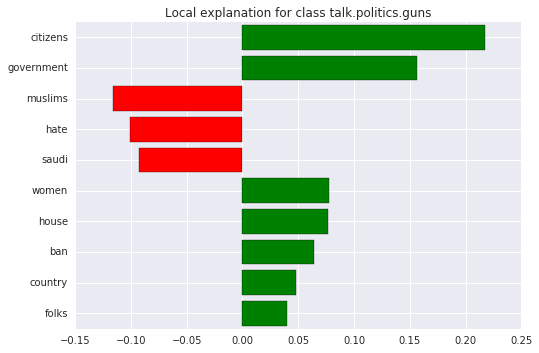

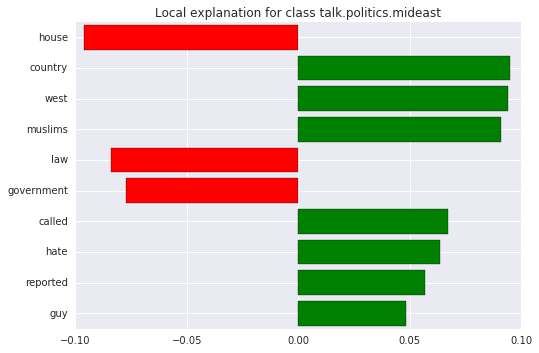

In [27]:
%%ml explain --detailview_only
model: ./train/model
labels: talk.politics.guns,talk.politics.mideast
type: text
data: $instance2

## Deploying Model to ML Engine

Now that we have a trained model, have analyzed the results, and have tested the model output locally, we are ready to deploy it to the cloud for real predictions. 

Deploying a model requires the files are on GCS. The next few cells makes a bucket on GCS, copies the locally trained model, and deploys it.

In [ ]:
!gsutil -q mb gs://bq-mlworkbench-20news-lab

In [46]:
# Move the regular model to GCS
!gsutil -m cp -r ./train/model gs://bq-mlworkbench-20news-lab

Copying file://./train/model/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://./train/model/assets.extra/schema.json [Content-Type=application/json]...
Copying file://./train/model/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://./train/model/variables/variables.index [Content-Type=application/octet-stream]...
Copying file://./train/model/assets.extra/features.json [Content-Type=application/json]...
/ [5/5 files][901.2 KiB/901.2 KiB] 100% Done                                    
Operation completed over 5 objects/901.2 KiB.                                    


See this doc https://cloud.google.com/ml-engine/docs/how-tos/managing-models-jobs for a the definition of ML Engine models and versions. An ML Engine version runs predictions and is contained in a ML Engine model. We will create a new ML Engine model, and depoly the TensorFlow graph as a ML Engine version. This can be done using gcloud (see https://cloud.google.com/ml-engine/docs/how-tos/deploying-models), or Datalab which we use below.

In [47]:
%%ml model deploy
path: gs://bq-mlworkbench-20news-lab
name: news.alpha

Waiting for operation "projects/bradley-playground/operations/create_news_alpha-1507958638739"
Done.


## How to Build Your Own Prediction Client

A common task is to call a deployed model from different applications. Below is an example of writing a python client to run prediction. 

Covering model permissions topics is outside the scope of this notebook, but for more information see https://cloud.google.com/ml-engine/docs/tutorials/python-guide and https://developers.google.com/identity/protocols/application-default-credentials .

In [48]:
from oauth2client.client import GoogleCredentials
from googleapiclient import discovery
from googleapiclient import errors

# Store your project ID, model name, and version name in the format the API needs.
api_path = 'projects/{your_project_ID}/models/{model_name}/versions/{version_name}'.format(
    your_project_ID=google.datalab.Context.default().project_id,
    model_name='news',
    version_name='alpha')

# Get application default credentials (possible only if the gcloud tool is
#  configured on your machine). See https://developers.google.com/identity/protocols/application-default-credentials
#  for more info.
credentials = GoogleCredentials.get_application_default()

# Build a representation of the Cloud ML API.
ml = discovery.build('ml', 'v1', credentials=credentials)

# Create a dictionary containing data to predict.
# Note that the data is a list of csv strings.
body = {
    'instances': ['nasa',
                  'windows ex']}

# Create a request
request = ml.projects().predict(
    name=api_path,
    body=body)

print('The JSON request: \n')
print(request.to_json())

# Make the call.
try:
    response = request.execute()
    print('\nThe response:\n')
    print(json.dumps(response, indent=2))
except errors.HttpError, err:
    # Something went wrong, print out some information.
    print('There was an error. Check the details:')
    print(err._get_reason())

The JSON request: 

{"body": "{\"instances\": [\"nasa\", \"windows ex\"]}", "resumable_uri": null, "headers": {"content-type": "application/json", "accept-encoding": "gzip, deflate", "accept": "application/json", "user-agent": "google-api-python-client/1.6.2 (gzip)"}, "uri": "https://ml.googleapis.com/v1/projects/bradley-playground/models/news/versions/alpha:predict?alt=json", "resumable": null, "methodId": "ml.projects.predict", "body_size": 37, "resumable_progress": 0, "method": "POST", "_in_error_state": false, "response_callbacks": []}

The response:

{
  "predictions": [
    {
      "probability": 0.09366906434297562, 
      "probability_5": 0.057013291865587234, 
      "probability_4": 0.06060284376144409, 
      "predicted": "sci.space", 
      "probability_3": 0.06113375723361969, 
      "probability_2": 0.06321851164102554, 
      "predicted_2": "rec.motorcycles", 
      "predicted_3": "rec.sport.baseball", 
      "predicted_4": "comp.graphics", 
      "predicted_5": "rec.auto

To demonstrate prediction client further, check API Explorer (https://developers.google.com/apis-explorer). it allows you to send raw HTTP requests to many Google APIs. This is useful for understanding the requests and response, and help you build your own client with your favorite language.

Please visit https://developers.google.com/apis-explorer/#search/ml%20engine/ml/v1/ml.projects.predict and enter the following values for each text box. 

In [154]:
# The output of this cell is placed in the name box
# Store your project ID, model name, and version name in the format the API needs.
api_path = 'projects/{your_project_ID}/models/{model_name}/versions/{version_name}'.format(
    your_project_ID=google.datalab.Context.default().project_id,
    model_name='news',
    version_name='alpha')
print('Place the following in the name box')
print(api_path)

Place the following in the name box
projects/bradley-playground/models/news/versions/v2


The fields text box can be empty.

Note that because we deployed the non-evaluation model, our depolyed model takes a csv input which only has one column. In general, the "instances" is a list of csv strings for models trained by MLWorkbench.

Click in the request body box, and note a small drop down menu appears in the FAR RIGHT of the input box. Slect "Freeform editor". Then enter the following in the request body box.

In [155]:
print('Place the following in the request body box')
request = {'instances': ['nasa', 'windows xp']}
print(json.dumps(request))

Place the following in the request body box
{"instances": ["nasa", "windows xp"]}


Then click the "Authorize and execute" button. The prediction results are returned in the browser.

## Cleaning up the deployed model

In [49]:
%%ml model delete
name: news.alpha

Waiting for operation "projects/bradley-playground/operations/delete_news_alpha-1507958747223"
Done.


In [157]:
%%ml model delete
name: news

Waiting for operation "projects/bradley-playground/operations/delete_model_news-1502830507"
Done.


In [50]:
# Delete the GCS bucket
!gsutil -m rm -r gs://bq-mlworkbench-20news-lab

Removing gs://bq-mlworkbench-20news-lab/predict_results_eval.csv#1504129989243557...
Removing gs://bq-mlworkbench-20news-lab/model/assets.extra/features.json#1507958604005929...
Removing gs://bq-mlworkbench-20news-lab/model/assets.extra/schema.json#1507958604006277...
Removing gs://bq-mlworkbench-20news-lab/model/saved_model.pb#1507958604075559...
Removing gs://bq-mlworkbench-20news-lab/model/variables/variables.data-00000-of-00001#1507958604075540...
Removing gs://bq-mlworkbench-20news-lab/model/variables/variables.index#1507958604007528...
/ [6/6 objects] 100% Done                                                       
Operation completed over 6 objects.                                              
Removing gs://bq-mlworkbench-20news-lab/...


In [ ]:
# Delete BQ table

bq.Dataset('newspredict').delete(delete_contents = True)